In [24]:
"""
This project takes in the MNIST training dataset and does stuff
"""

import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

train_df = pd.read_csv('digit-recognizer/train.csv')

train_labels = train_df['label']

In [25]:
train_labels.values[:15]

array([1, 0, 1, 4, 0, 0, 7, 3, 5, 3, 8, 9, 1, 3, 3])

In [26]:
filename = 'training_data.p'

### loading the data if it's been previously generated ###

try:
    infile = open(filename,'rb')
    train_input = pickle.load(infile)
    infile.close()

### Generating and saving the data ###
except:
    train_df.drop(['label'],inplace=True, axis=1)
    np_train = train_df.to_numpy()
    
    two_d = np.reshape(np_train[0],[1,28,28])
    train_input = two_d

    for ind in tqdm(range(1,np.shape(np_train)[0])):
    #     if ind == 10:
    #         break
        two_d = np.reshape(np_train[ind],[1,28,28])
        train_input = np.concatenate((train_input, two_d), axis = 0)

    print(np.shape(train_input))

    outfile = open(filename,'wb')
    pickle.dump(train_input, outfile)
    outfile.close()

    print('saved successfully!')

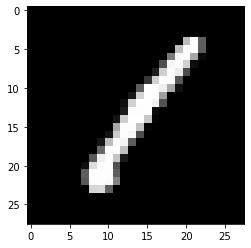

In [27]:
from matplotlib import pyplot as plt
plt.imshow(train_input[0], cmap='gray')

In [28]:
class Net(nn.Module):
    
    """
    from https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
    """

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5) #in channels, out channels (AKA # of kernels), kernel size
        self.conv2 = nn.Conv2d(6, 16, 5) 
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120) # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
#         x = x.double()
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # max_pool2d(__,2) halves the height and width
#         x = F.max_pool2d(F.leaky_relu(self.conv1(x), 0.01), (2, 2)) #trying with leaky
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
#         x = F.max_pool2d(F.leaky_relu(self.conv2(x), 0.01), 2) #trying with leaky
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
#         x = F.leaky_relu(self.fc1(x), 0.01)
#         x = F.leaky_relu(self.fc2(x), 0.01)
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [29]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [30]:
input = torch.randn(1, 1, 28, 28)
#input = torch.randn(28, 28)
out = net(input)
print(out)

tensor([[ 0.0798,  0.0272, -0.0219, -0.0451, -0.0631, -0.0714,  0.0434, -0.0780,
         -0.0254,  0.0821]], grad_fn=<AddmmBackward>)


In [31]:
net.zero_grad()
out.backward(torch.randn(1, 10))

In [32]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.9849, grad_fn=<MseLossBackward>)


In [33]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0025,  0.0009, -0.0036,  0.0014,  0.0091, -0.0180])


In [34]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data * learning_rate)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(train_input, train_labels.values, test_size=0.20, random_state=42)
print(f'training data shape: {np.shape(X_train)}')
print(f'training labels shape: {np.shape(y_train)}')

training data shape: (33600, 28, 28)
training labels shape: (33600,)


In [36]:
# Check out: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html for dataset info
# looks like pytorch likes to have datasets structured as classes and is mor picky than TF

class CustomMNISTDataset():
    def __init__(self, labels, imgs):
        temp_imgs = ((imgs-128)/128).astype(np.float32)
        self.imgs = torch.unsqueeze(torch.from_numpy(temp_imgs), 1)
#         self.labels = labels
        self.labels = F.one_hot(torch.tensor(labels), num_classes=10) # one hot encodes the labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return ( 
            self.imgs[idx],
            self.labels[idx]
        )

train_DS = CustomMNISTDataset(labels = y_train, imgs = X_train)
test_DS = CustomMNISTDataset(labels = y_test, imgs = X_test)

train_loader = torch.utils.data.DataLoader(train_DS, batch_size=50)
val_loader = torch.utils.data.DataLoader(test_DS, batch_size=1)

In [37]:
# print(train_DS.__dict__)

In [38]:
n_epochs = 3
batch_size_train = 50
batch_size_test = 10
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [39]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [40]:
def train(epoch):
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = net(data)
#         loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()), end='\r')
            train_losses.append(loss.item())
            train_counter.append(
            (batch_idx*50) + ((epoch-1)*len(train_loader.dataset)))
#             torch.save(network.state_dict(), '/results/model.pth')
#             torch.save(optimizer.state_dict(), '/results/optimizer.pth')
            ### Figure out how to save later, fuck dis shit for now ###

In [41]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = net(data)
#             test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss = criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [42]:
# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [43]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

RuntimeError: shape '[1, 1]' is invalid for input of size 10